In [31]:
import numpy as np
import scipy.io
import imageio
import h5py
import os
import matplotlib
import matplotlib.colors
import matplotlib.pyplot as plt
import skimage.transform 
import random
import torchvision
import torch
from PIL import Image
from skimage.io import imread_collection
import imageio
from skimage import transform
import matplotlib.image as mpimg
from PIL import Image
import glob
import argparse
import os
import time
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim
from torch.optim.lr_scheduler import LambdaLR
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch import nn
import torch.nn.functional as F

from sklearn.metrics import mean_squared_error 
from torch.autograd.variable import Variable
from skimage.color import rgb2gray
#from tensorboardX import SummaryWriter
# from ipynb.fs.full.utils import load_ckpt
# from ipynb.fs.full.utils import save_ckpt
# from ipynb.fs.full.utils import print_log


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **DATA LOADER** => no changes

In [3]:

class SUNRGBD(Dataset):
    def __init__(self, transform=None, phase_train=True, data_dir=None):

        self.phase_train = phase_train
        self.transform = transform
        self.img_dir_train=Z_vis
        self.depth_dir_train=Z_ir
        

    def __len__(self):
        if self.phase_train:
            return len(self.img_dir_train)
        else:
            return len(self.img_dir_test)

    def __getitem__(self, idx):
        if self.phase_train:
            img_dir = self.img_dir_train
            depth_dir = self.depth_dir_train
        image = img_dir[idx]
        depth = depth_dir[idx]

        sample = {'image': image, 'depth': depth}

        if self.transform:
            sample = self.transform(sample)

            return sample


class RandomHSV(object):
    """
        Args:
            h_range (float tuple): random ratio of the hue channel,
                new_h range from h_range[0]*old_h to h_range[1]*old_h.
            s_range (float tuple): random ratio of the saturation channel,
                new_s range from s_range[0]*old_s to s_range[1]*old_s.
            v_range (int tuple): random bias of the value channel,
                new_v range from old_v-v_range to old_v+v_range.
        Notice:
            h range: 0-1
            s range: 0-1
            v range: 0-255
        """

    def __init__(self, h_range, s_range, v_range):
        assert isinstance(h_range, (list, tuple)) and \
               isinstance(s_range, (list, tuple)) and \
               isinstance(v_range, (list, tuple))
        self.h_range = h_range
        self.s_range = s_range
        self.v_range = v_range

    def __call__(self, sample):
        img = sample['image']
        img_hsv = matplotlib.colors.rgb_to_hsv(img)
        img_h, img_s, img_v = img_hsv[:, :, 0], img_hsv[:, :, 1], img_hsv[:, :, 2]
        h_random = np.random.uniform(min(self.h_range), max(self.h_range))
        s_random = np.random.uniform(min(self.s_range), max(self.s_range))
        v_random = np.random.uniform(-min(self.v_range), max(self.v_range))
        img_h = np.clip(img_h * h_random, 0, 1)
        img_s = np.clip(img_s * s_random, 0, 1)
        img_v = np.clip(img_v + v_random, 0, 255)
        img_hsv = np.stack([img_h, img_s, img_v], axis=2)
        img_new = matplotlib.colors.hsv_to_rgb(img_hsv)
        return {'image': img_new, 'depth': sample['depth']}


class scaleNorm(object):
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        # Bi-linear
        image = skimage.transform.resize(image, (image_h, image_w), order=1,
                                         mode='reflect', preserve_range=True)
        # Nearest-neighbor
        depth = skimage.transform.resize(depth, (image_h, image_w), order=0,
                                         mode='reflect', preserve_range=True)
#         print("scalenorm")
        return {'image': image, 'depth': depth}


class RandomScale(object):
    def __init__(self, scale):
        self.scale_low = min(scale)
        self.scale_high = max(scale)

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        target_scale = random.uniform(self.scale_low, self.scale_high)
        # (H, W, C)
        target_height = int(round(target_scale * image.shape[0]))
        target_width = int(round(target_scale * image.shape[1]))
        # Bi-linear
        image = skimage.transform.resize(image, (target_height, target_width),
                                         order=1, mode='reflect', preserve_range=True)
        # Nearest-neighbor
        depth = skimage.transform.resize(depth, (target_height, target_width),
                                         order=0, mode='reflect', preserve_range=True)
        
        
        return {'image': image, 'depth': depth}


class RandomCrop(object):
    def __init__(self, th, tw):
        self.th = int(th)
        self.tw = int(tw)
        print('th')
        print(th)

    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        h = image.shape[0]
        w = image.shape[1]
        print('h')
        print(h)
        print('diff')
        print(self.th)
        a=int(self.th)
        b=int( self.tw)
        print(a)
        print(b)
        i = random.randint(0,a)
        j = random.randint(0,b)
        return {'image': image[i:i + image_h, j:j + image_w, :],
                'depth': depth[i:i + image_h, j:j + image_w]}
  
class RandomFlip(object):
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        if random.random() > 0.5:
            image = np.fliplr(image).copy()
            depth = np.fliplr(depth).copy()
        return {'image': image, 'depth': depth}


# Transforms on torch.*Tensor
class Normalize(object):
    def __call__(self, sample):
        image, depth = sample['image'], sample['depth']
        image = image / 255
        image = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                 std=[0.229, 0.224, 0.225])(image)
        depth = torchvision.transforms.Normalize(mean=[19050],
                                                std=[9650])(depth)
        sample['image'] = image
        sample['depth'] = depth
#         print("normalize")
        return sample


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, depth= sample['image'], sample['depth']

#         image = image.transpose((2, 0, 1))
#         image = image / 255 
        image = np.expand_dims(image, 0).astype(np.float)

        depth = np.expand_dims(depth, 0).astype(np.float)
        depth = depth/255
        return {'image': torch.from_numpy(image).float(),
              'depth': torch.from_numpy(depth).float()}

 ## **UTILS** =>  no changes

In [4]:
import numpy as np
from torch import nn
import torch
import os

med_frq = [0.382900, 0.452448, 0.637584, 0.377464, 0.585595,
           0.479574, 0.781544, 0.982534, 1.017466, 0.624581,
           2.589096, 0.980794, 0.920340, 0.667984, 1.172291,
           0.862240, 0.921714, 2.154782, 1.187832, 1.178115,
           1.848545, 1.428922, 2.849658, 0.771605, 1.656668,
           4.483506, 2.209922, 1.120280, 2.790182, 0.706519,
           3.994768, 2.220004, 0.972934, 1.481525, 5.342475,
           0.750738, 4.040773]

model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

label_colours = [(0, 0, 0),
                 # 0=background
                 (148, 65, 137), (255, 116, 69), (86, 156, 137),
                 (202, 179, 158), (155, 99, 235), (161, 107, 108),
                 (133, 160, 103), (76, 152, 126), (84, 62, 35),
                 (44, 80, 130), (31, 184, 157), (101, 144, 77),
                 (23, 197, 62), (141, 168, 145), (142, 151, 136),
                 (115, 201, 77), (100, 216, 255), (57, 156, 36),
                 (88, 108, 129), (105, 129, 112), (42, 137, 126),
                 (155, 108, 249), (166, 148, 143), (81, 91, 87),
                 (100, 124, 51), (73, 131, 121), (157, 210, 220),
                 (134, 181, 60), (221, 223, 147), (123, 108, 131),
                 (161, 66, 179), (163, 221, 160), (31, 146, 98),
                 (99, 121, 30), (49, 89, 240), (116, 108, 9),
                 (161, 176, 169), (80, 29, 135), (177, 105, 197),
                 (139, 110, 246)]


class CrossEntropyLoss2d(nn.Module):
    def __init__(self, weight=med_frq):
        super(CrossEntropyLoss2d, self).__init__()
        self.ce_loss =F.mse_loss(out,depth)

    def forward(self, inputs_scales, targets_scales):
        losses = []
        for inputs, targets in zip(inputs_scales, targets_scales):
            mask = targets > 0
            targets_m = targets.clone()
            targets_m[mask] -= 1
            loss_all = self.ce_loss(inputs, targets_m.long())
            losses.append(torch.sum(torch.masked_select(loss_all, mask)) / torch.sum(mask.float()))
        total_loss = sum(losses)
        return total_loss


def color_label(label):
    label = label.clone().cpu().data.numpy()
    colored_label = np.vectorize(lambda x: label_colours[int(x)])

    colored = np.asarray(colored_label(label)).astype(np.float32)
    colored = colored.squeeze()

    try:
        return torch.from_numpy(colored.transpose([1, 0, 2, 3]))
    except ValueError:
        return torch.from_numpy(colored[np.newaxis, ...])


def print_log(global_step, epoch, local_count, count_inter, dataset_size, loss, time_inter):
    print('Step: {:>5} Train Epoch: {:>3} [{:>4}/{:>4} ({:3.1f}%)]    '
          'Loss: {:.6f} [{:.2f}s every {:>4} data]'.format(
        global_step, epoch, local_count, dataset_size,
        100. * local_count / dataset_size, loss.data, time_inter, count_inter))


def save_ckpt(ckpt_dir, model, optimizer, global_step, epoch, local_count, num_train):
    # usually this happens only on the start of a epoch
    epoch_float = epoch + (local_count / num_train)
    state = {
        'global_step': global_step,
        'epoch': epoch_float,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    ckpt_model_filename = "ckpt_epoch_{:0.2f}.pth".format(epoch_float)
    path = os.path.join(ckpt_dir, ckpt_model_filename)
    torch.save(state, path)
    print('{:>2} has been successfully saved'.format(path))


def load_ckpt(model, optimizer, model_file, device):
    if os.path.isfile(model_file):
        print(model_file)
        print("=> loading checkpoint '{}'".format(model_file))
        if device.type == 'cuda':
            checkpoint = torch.load(model_file)
        else:
            checkpoint = torch.load(model_file, map_location=lambda storage, loc: storage)
        model.load_state_dict(checkpoint['state_dict'])
        if optimizer:
            optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(model_file, checkpoint['epoch']))
        step = checkpoint['global_step']
        epoch = checkpoint['epoch']
        return step, epoch
    else:
        print("=> no checkpoint found at '{}'".format(model_file))
        

## **GENERATOR MODULE** => no changes

In [5]:
#new model file
import torch
from torch import nn
import math
import torch.utils.model_zoo as model_zoo
from torch.utils.checkpoint import checkpoint


class RedNet(nn.Module):
    def __init__(self, pretrained=False):
#         print('it is in rednet init')
        super(RedNet, self).__init__()
        block = Bottleneck
        transblock = TransBasicBlock
        layers = [3, 4, 6, 3]
        # original resnet
        self.inplanes = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        # resnet for depth channel
        self.inplanes = 64
        self.conv1_d = nn.Conv2d(1,64, kernel_size=7, stride=2, padding=3,
                                 bias=False)
        self.bn1_d = nn.BatchNorm2d(64)
        self.layer1_d = self._make_layer(block,64, layers[0])
        self.layer2_d = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3_d = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4_d = self._make_layer(block, 512, layers[3], stride=2)

        self.inplanes = 512
        self.deconv1 = self._make_transpose(transblock, 256, 6, stride=2)
        self.deconv2 = self._make_transpose(transblock, 128, 4, stride=2)
        self.deconv3 = self._make_transpose(transblock, 64, 3, stride=2)
        self.deconv4 = self._make_transpose(transblock, 64, 3, stride=2)

        self.agant0 = self._make_agant_layer(64, 64)
        self.agant1 = self._make_agant_layer(64 * 4, 64)
        self.agant2 = self._make_agant_layer(128 * 4, 128)
        self.agant3 = self._make_agant_layer(256 * 4, 256)
        self.agant4 = self._make_agant_layer(512* 4,512)
        # final block
        self.inplanes = 64
        self.final_conv = self._make_transpose(transblock, 64, 3)

        self.final_deconv = nn.ConvTranspose2d(self.inplanes, 1,kernel_size=2,
                                               stride=2, padding=0, bias=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
                
               

        if pretrained:
            self._load_resnet_pretrained()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []

        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_transpose(self, block, planes, blocks, stride=1):

        upsample = None
        if stride != 1:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.inplanes, planes,
                                   kernel_size=2, stride=stride,
                                   padding=0, bias=False),
                nn.BatchNorm2d(planes),
            )
        elif self.inplanes != planes:
            upsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []

        for i in range(1, blocks):
            layers.append(block(self.inplanes, self.inplanes))

        layers.append(block(self.inplanes, planes, stride, upsample))
        self.inplanes = planes

        return nn.Sequential(*layers)

    def _make_agant_layer(self, inplanes, planes):

        layers = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=1,
                      stride=1, padding=0, bias=False),
            nn.BatchNorm2d(planes),
            nn.ReLU(inplace=True)
        )
        return layers

    def _load_resnet_pretrained(self):
        pretrain_dict = model_zoo.load_url(model_urls['resnet50'])
        model_dict = {}
        state_dict = self.state_dict()
        for k, v in pretrain_dict.items():
            if k in state_dict:
                if k.startswith('conv1'):  # the first conv_op
                    model_dict[k] = v
                    model_dict[k.replace('conv1', 'conv1_d')] = torch.mean(v, 1).data. \
                        view_as(state_dict[k.replace('conv1', 'conv1_d')])

                elif k.startswith('bn1'):
                    model_dict[k] = v
                    model_dict[k.replace('bn1', 'bn1_d')] = v
                elif k.startswith('layer'):
                    model_dict[k] = v
                    model_dict[k[:6] + '_d' + k[6:]] = v
        state_dict.update(model_dict)
        self.load_state_dict(state_dict)

    def forward_downsample(self, rgb, depth):

        x = self.conv1(rgb)
        x = self.bn1(x)
        x = self.relu(x)
        depth = self.conv1_d(depth)
        depth = self.bn1_d(depth)
        depth = self.relu(depth)

        fuse0 = x + depth

        x = self.maxpool(fuse0)
        depth = self.maxpool(depth)

        # block 1
        x = self.layer1(x)
        depth = self.layer1_d(depth)
        fuse1 = x + depth
        # block 2
        x = self.layer2(fuse1)
        depth = self.layer2_d(depth)
        fuse2 = x + depth
        # block 3
        x = self.layer3(fuse2)
        depth = self.layer3_d(depth)
        fuse3 = x + depth
        # block 4
        x = self.layer4(fuse3)
        depth = self.layer4_d(depth)
        fuse4 = x + depth
        return fuse0, fuse1, fuse2, fuse3, fuse4

    def forward_upsample(self, fuse0, fuse1, fuse2, fuse3, fuse4):

        agant4 = self.agant4(fuse4)
        # upsample 1
        x = self.deconv1(agant4)
        x = x + self.agant3(fuse3)
        # upsample 2
        x = self.deconv2(x)
        x = x + self.agant2(fuse2)
        # upsample 3
        x = self.deconv3(x)
        x = x + self.agant1(fuse1)
        # upsample 4
        x = self.deconv4(x)
        x = x + self.agant0(fuse0)
        # final
        x = self.final_conv(x)
        out = self.final_deconv(x)

        if self.training:
            return out
        return out

    def forward(self, rgb, depth, phase_checkpoint=False):

        if phase_checkpoint:
            depth.requires_grad_()
            fuses = checkpoint(self.forward_downsample, rgb, depth)
            out = checkpoint(self.forward_upsample, *fuses)
        else:
            fuses = self.forward_downsample(rgb, depth)
            out = self.forward_upsample(*fuses)

        return out


    def conv3x3(in_planes, out_planes, stride=1):
    #"3x3 convolution with padding"
        return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class TransBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, upsample=None, **kwargs):
        super(TransBasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        if upsample is not None and stride != 1:
            self.conv2 = nn.ConvTranspose2d(inplanes, planes,
                                            kernel_size=3, stride=stride, padding=1,
                                            output_padding=1, bias=False)
        else:
            self.conv2 = conv3x3(inplanes, planes, stride)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            residual = self.upsample(x)

        out += residual
        out = self.relu(out)

        return out


## **LOAD PRETRAINED GENERATOR** => Specify name of pretrained weights location

In [30]:
pretrained_file_loaction="/content/drive/My Drive/ckpt_epoch_10.00.pth"
cuda_available=True
device = torch.device("cuda:0" if cuda_available and torch.cuda.is_available() else "cpu")
image_w = 640
image_h = 480
model = RedNet(pretrained=False)
load_ckpt(model, None, pretrained_file_loaction, device)
model.eval()
model.to(device)

/content/drive/My Drive/ckpt_epoch_10.00.pth
=> loading checkpoint '/content/drive/My Drive/ckpt_epoch_10.00.pth'
=> loaded checkpoint '/content/drive/My Drive/ckpt_epoch_10.00.pth' (epoch 10.0)


RedNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## **INFERENCE** => Specify names of file

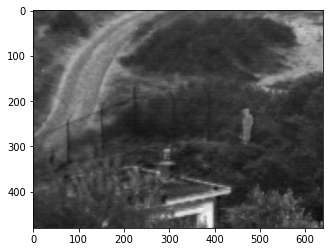

In [29]:
visible_location='/content/drive/My Drive/dataset/vis/62_vis.bmp'
infrared_location = '/content/drive/My Drive/dataset/ir/62_ir.bmp'
vis = imageio.imread(visible_location)
inf = imageio.imread(infrared_location)

vis = skimage.transform.resize(vis, (image_h, image_w), order=1,
                                     mode='reflect', preserve_range=True)
    # Nearest-neighbor
inf = skimage.transform.resize(inf, (image_h, image_w), order=0,
                                     mode='reflect', preserve_range=True)
vis = rgb2gray(vis / 255)
inf = rgb2gray(inf/255 )
vis_numpy= vis
inf_numpy = inf
vis = torch.from_numpy(vis).float().unsqueeze_(0).unsqueeze_(0).to(device)
inf = torch.from_numpy(inf).float().unsqueeze_(0).unsqueeze_(0).to(device)
pred = model(inf,vis)
predout=pred.cpu().detach().numpy()
out_2=predout[0,0,:,:]
plt.imshow(out_2,cmap= 'gray')